Dataset Description from Source:

- Multivariate Time Series data of Fatigued and Non-Fatigued Running from Inertial Measurement Units


The data captured came from mounting a single Shimmer3 IMU on the lumbar of 19 recreational runners. The participants were all regular runners and injury free. The study protocol was reviewed and approved by the human research ethics committee at University College Dublin.

The data was collected in three segments; in the first, the participant completed a 400m run at a comfortable pace; the second segment consisted of a beep test which acted as the fatiguing protocol for this study; and the last segment where the runner was required to complete the 400m run at their comfortable pace, this time in their fatigued state. The beep test requires the runner to continuously run between two points 20m apart following an audio which produces 'beeps' indicating when the person should begin running from one end to the other. The test eventually requires the runner to increase their pace as the interval between the 'beeps' reduces as the test progresses. The fatiguing protocol ends when the runner is unable to keep up the increase in pace. The runs were all done on an outdoor running track. The sensor captured acceleration, angular velocity and magnetometer data throughout the three stages of the trials at a sampling rate of 256Hz. The data included here are segmented strides from the two 400m runs of each of the 19 participants. The labels on the data represent the participant number and whether it was a fatigued stride ('F') or a not fatigued stride ('NF').
The data used from the sensors includes data from the accelerometer in three directions (X, Y, Z) and the gyroscope in three directions (X, Y, Z). The direction of each of the axis is relative to the sensor. Two extra signals, magnitude acceleration and magnitude gyroscope were derived from the component signals and included in the analysis.

-------

Magnitude acceleration signal is the one used in this study, and it is defined as the square root of the squared sum of each of the directional components.
A_mag = $\sqrt{(X^2 + Y^2 + Z^2)}$

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

from sktime.transformations.panel.rocket import MiniRocket, Rocket
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested, from_multi_index_to_nested

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer


In [108]:
ROOT_DIR = Path(os.getcwd()).parent
filename = 'Accel_mag_all.csv'

df = pd.read_csv(ROOT_DIR / 'data' / filename, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,4,F,1.49,4.09,9.27,12.70,12.80,12.00,12.40,13.20,...,9.53,9.30,9.61,9.25,8.07,7.62,8.76,9.61,7.63,3.57
1,4,F,7.35,7.25,7.80,7.94,7.34,6.48,5.87,5.47,...,8.92,7.66,7.76,8.28,8.99,10.20,11.60,11.90,10.70,8.72
2,4,F,9.31,9.06,9.41,9.51,9.23,9.14,9.08,8.45,...,11.40,10.50,9.63,9.29,9.75,10.20,10.10,10.10,10.20,10.00
3,4,F,9.82,10.50,9.86,10.20,10.90,10.60,9.97,9.50,...,11.50,10.60,9.07,7.65,6.83,6.67,6.28,5.09,4.77,7.00
4,4,F,4.68,3.68,4.63,5.01,4.05,3.40,4.00,4.62,...,11.90,10.60,11.10,12.90,14.00,13.60,13.00,12.80,11.50,8.12


In [109]:
# df = (df.reset_index(drop=False).rename(columns={'index':'SegmentID'}))
# df.columns = ['SegmentID','Subject','Target'] + [i for i in range(180)]

df.columns = ['Subject','Target'] + [i for i in range(180)]
df.head()


,Subject,Target,0,1,2,3,4,5,6,7,...,170,171,172,173,174,175,176,177,178,179
0,4,F,1.49,4.09,9.27,12.70,12.80,12.00,12.40,13.20,...,9.53,9.30,9.61,9.25,8.07,7.62,8.76,9.61,7.63,3.57
1,4,F,7.35,7.25,7.80,7.94,7.34,6.48,5.87,5.47,...,8.92,7.66,7.76,8.28,8.99,10.20,11.60,11.90,10.70,8.72
2,4,F,9.31,9.06,9.41,9.51,9.23,9.14,9.08,8.45,...,11.40,10.50,9.63,9.29,9.75,10.20,10.10,10.10,10.20,10.00
3,4,F,9.82,10.50,9.86,10.20,10.90,10.60,9.97,9.50,...,11.50,10.60,9.07,7.65,6.83,6.67,6.28,5.09,4.77,7.00
4,4,F,4.68,3.68,4.63,5.01,4.05,3.40,4.00,4.62,...,11.90,10.60,11.10,12.90,14.00,13.60,13.00,12.80,11.50,8.12


### EDA

In [110]:
df.shape

(6006, 182)

1. How many records per Runner ID are there?

In [111]:
df.filter(regex='^0$').value_counts()

2.550     45
2.120     35
2.420     34
2.170     34
2.720     26
          ..
0.853      1
0.852      1
0.843      1
0.841      1
34.500     1
Length: 1192, dtype: int64

2. Number of runners

In [112]:
df.filter(regex='^0$').nunique()

0    1192
dtype: int64

3. Fatigued stride (F) vs. Non-Fatigued stride (NF) class 

The dataset seems to be balanced fairly well with F and NF classes

In [113]:
df.filter(regex='^1$').value_counts()

1     
10.100    19
2.700     19
2.180     19
3.670     18
2.060     17
          ..
0.957      1
0.956      1
0.952      1
0.946      1
38.500     1
Length: 1075, dtype: int64

### Plotting

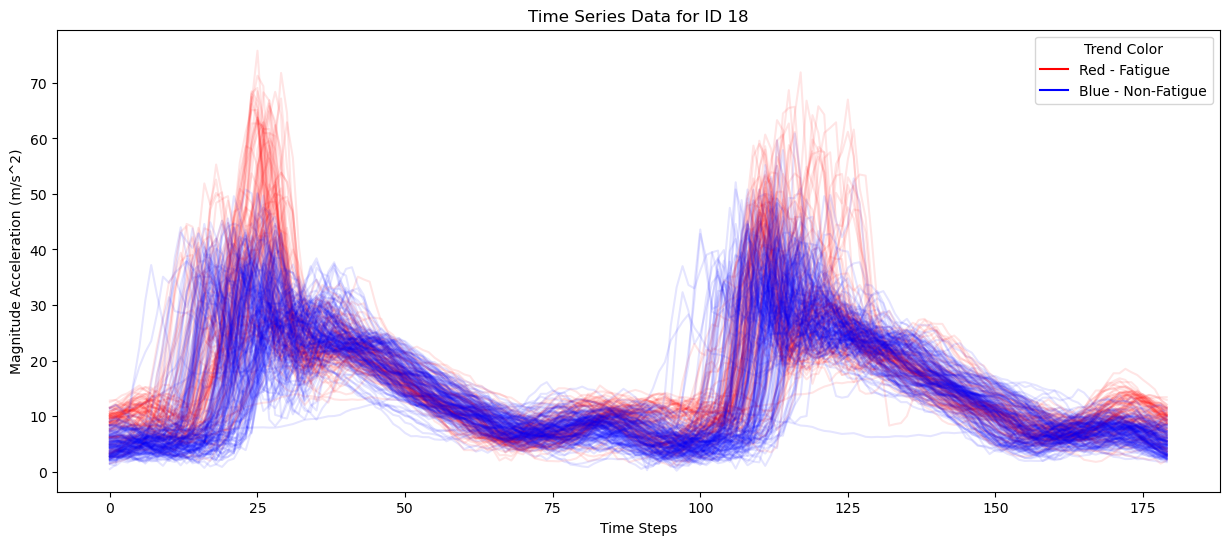

In [213]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_individual_id_ts_with_flag(df, id):
    # Filter the data for the given ID
    df_sample = df[df['Subject'] == id]

    # Separate data based on the binary target flag
    df_F = df_sample[df_sample['Target'] == 'F'].drop(columns=['Subject','Target']).T
    df_NF = df_sample[df_sample['Target'] == 'NF'].drop(columns=['Subject','Target']).T

    # Plotting
    plt.figure(figsize=(15, 6))
    if not df_F.empty:
        plt.plot(df_F, color='red', label='F', alpha=0.1)  # Set alpha value to make the line more transparent
    if not df_NF.empty:
        plt.plot(df_NF, color='blue', label='NF', alpha=0.1)  # Set alpha value to make the line more transparent
    
    plt.title(f'Time Series Data for ID {id}')
    plt.xlabel('Time Steps')
    plt.ylabel('Magnitude Acceleration (m/s^2)')
    # Custom Legend
    red_line = mlines.Line2D([], [], color='red', label='Red - Fatigue')
    blue_line = mlines.Line2D([], [], color='blue', label='Blue - Non-Fatigue')
    plt.legend(handles=[red_line, blue_line], title='Trend Color')
    plt.show()

# Execute the function for an example ID, e.g., 5
plot_individual_id_ts_with_flag(df, 18)


#### Data Preparation for sktime modeling

In [137]:
df_long = df.copy()
df_long = df_long.reset_index(drop=False).rename(columns={'index':'SegmentID'})
df_long = pd.melt(df_long, id_vars=['SegmentID','Subject','Target'], var_name='timestep', value_name='Accel')
df_long.head()


,SegmentID,Subject,Target,timestep,Accel
0,0,4,F,0,1.49
1,1,4,F,0,7.35
2,2,4,F,0,9.31
3,3,4,F,0,9.82
4,4,4,F,0,4.68


In [138]:
df_long.tail()

,SegmentID,Subject,Target,timestep,Accel
1081075,6001,23,NF,179,4.77
1081076,6002,23,NF,179,2.52
1081077,6003,23,NF,179,5.42
1081078,6004,23,NF,179,13.40
1081079,6005,23,NF,179,12.40


In [139]:
df_long.shape


(1081080, 5)

In [143]:
df_sktime = df_long.copy()
df_sktime = df_sktime.sort_values(['SegmentID','timestep', 'Subject'])
df_sktime.reset_index(drop=True, inplace=True)
df_sktime.head()


,SegmentID,Subject,Target,timestep,Accel
0,0,4,F,0,1.49
1,0,4,F,1,4.09
2,0,4,F,2,9.27
3,0,4,F,3,12.70
4,0,4,F,4,12.80


Review how the data for one segment looks like

In [144]:
df_sktime[df_sktime['SegmentID'] == 0]

,SegmentID,Subject,Target,timestep,Accel
0,0,4,F,0,1.49
1,0,4,F,1,4.09
2,0,4,F,2,9.27
3,0,4,F,3,12.70
4,0,4,F,4,12.80
...,...,...,...,...,...
175,0,4,F,175,7.62
176,0,4,F,176,8.76
177,0,4,F,177,9.61
178,0,4,F,178,7.63


In [148]:

df_X, df_y = df_sktime.drop(columns=['Subject','Target']), df_sktime['Target']
y = df_sktime.groupby('SegmentID')['Target'].first()
df_X.set_index(['SegmentID','timestep'], inplace=True)
df_X.head()


Accel
SegmentID timestep       
0         0          1.49
          1          4.09
          2          9.27
          3         12.70
          4         12.80

In [149]:
y.head()

SegmentID
0    F
1    F
2    F
3    F
4    F
Name: Target, dtype: object

In [150]:
df_X_nested = from_multi_index_to_nested(multi_ind_dataframe=df_X, instance_index='SegmentID')
df_X_nested

,Accel
SegmentID,
0,0 1.49 1 4.09 2 9.27 3 ...
1,0 7.35 1 7.25 2 7.80 3 ...
2,0 9.31 1 9.06 2 9.41 3 ...
3,0 9.82 1 10.50 2 9.86 3 ...
4,0 4.68 1 3.68 2 4.63 3 ...
...,...
6001,0 7.50 1 7.74 2 7.42 3 7.1...
6002,0 4.28 1 4.57 2 4.24 3 4.1...
6003,0 1.15 1 1.57 2 4.37 3 5.3...


### Modeling

In [151]:
X_new = df_X_nested
y_new = y
groups = df['Subject']

y_new = y_new.replace({'F':1, 'NF':0})

In [154]:
X_new.shape, y_new.shape, groups.shape

((6006, 1), (6006,), (6006,))

Try Rocket pipeline with Ridge classifier 

In [157]:
rocket_pipeline_ridge = make_pipeline(
    Rocket(num_kernels=1000, random_state=1111),
    StandardScaler(),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)

Globalized Classification - using Leave one subject out LOSO 

In [167]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X_new, y_new, groups)
Rocket_score_glob = []
for i, (train_idx, test_idx) in enumerate(logo.split(X_new, y_new, groups)):
    rocket_pipeline_ridge.fit(X_new.iloc[train_idx], y_new.iloc[train_idx])
    Rocket_score = rocket_pipeline_ridge.score(X_new.iloc[test_idx], y_new.iloc[test_idx])
    Rocket_score_glob.append(Rocket_score)

In [168]:
# Look at the metrics with precision of 3 decimals
print("Global model results")
print(f"Mean accuracy: {format(np.mean(Rocket_score_glob), '.3f')}")
print(f"Standard deviation: {format(np.std(Rocket_score_glob), '.3f')}")
print(f"Min accuracy: {format(np.min(Rocket_score_glob), '.3f')}")
print(f"Max accuracy: {format(np.max(Rocket_score_glob), '.3f')}")

Global model results
Mean accuracy: 0.587
Standard deviation: 0.084
Min accuracy: 0.484
Max accuracy: 0.737


Personalized Classification

In [207]:
Rocket_score_per_sub = []
for i, (train_idx, test_idx) in enumerate(logo.split(X_new, y_new, groups)):

    print(f"Processing next subject...")
    print(f"Subject: {groups.iloc[test_idx].iat[0]}")

    label = y_new.iloc[test_idx]
    X_s = X_new.iloc[test_idx]
    # print(X_s.shape, label.shape)
    
    # Identify the indices of each class
    idx_0 = np.where(label == 0)[0]
    idx_1 = np.where(label == 1)[0]

    # Split each class into train and test
    class_0_split_idx = int(len(idx_0) * 0.8)
    class_1_split_idx = int(len(idx_1) * 0.8)

    X_train = pd.concat([X_s.iloc[idx_0[:class_0_split_idx]], X_s.iloc[idx_1[:class_1_split_idx]]])
    y_train = pd.concat([label.iloc[idx_0[:class_0_split_idx]], label.iloc[idx_1[:class_1_split_idx]]])

    X_test = pd.concat([X_s.iloc[idx_0[class_0_split_idx:]], X_s.iloc[idx_1[class_1_split_idx:]]])
    y_test = pd.concat([label.iloc[idx_0[class_0_split_idx:]], label.iloc[idx_1[class_1_split_idx:]]])

    rocket_pipeline_ridge.fit(X_train, y_train)

    Rocket_score = rocket_pipeline_ridge.score(X_test, y_test)
    Rocket_score_per_sub.append(Rocket_score)
    

Processing next subject...
Subject: 4
Processing next subject...
Subject: 5
Processing next subject...
Subject: 6
Processing next subject...
Subject: 7
Processing next subject...
Subject: 8
Processing next subject...
Subject: 9
Processing next subject...
Subject: 10
Processing next subject...
Subject: 11
Processing next subject...
Subject: 12
Processing next subject...
Subject: 13
Processing next subject...
Subject: 14
Processing next subject...
Subject: 15
Processing next subject...
Subject: 17
Processing next subject...
Subject: 18
Processing next subject...
Subject: 19
Processing next subject...
Subject: 20
Processing next subject...
Subject: 21
Processing next subject...
Subject: 22
Processing next subject...
Subject: 23


In [208]:
# Look at the metrics with precision of 3 decimals
print("Personalized model results")
print(f"Mean accuracy: {format(np.mean(Rocket_score_per_sub), '.3f')}")
print(f"Standard deviation: {format(np.std(Rocket_score_per_sub), '.3f')}")
print(f"Min accuracy: {format(np.min(Rocket_score_per_sub), '.3f')}")
print(f"Max accuracy: {format(np.max(Rocket_score_per_sub), '.3f')}")

Personalized model results
Mean accuracy: 0.962
Standard deviation: 0.042
Min accuracy: 0.875
Max accuracy: 1.000


#### Visualize Results

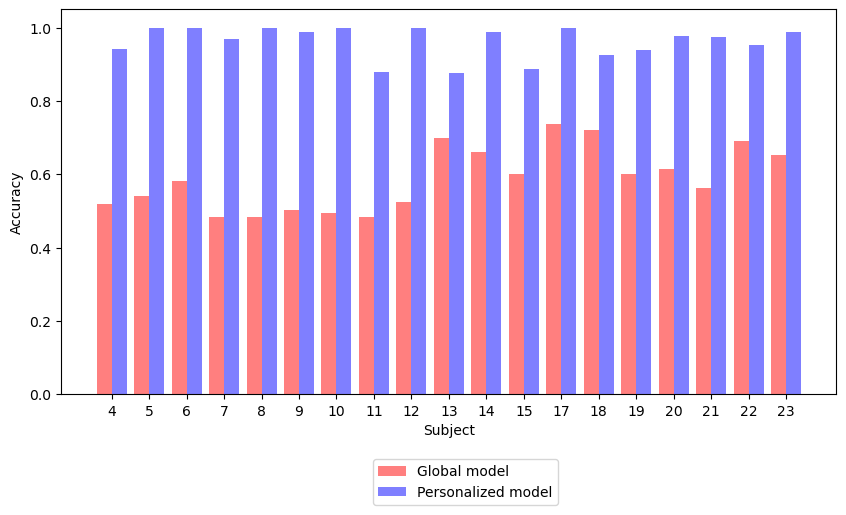

In [209]:
# Define the width of the bars
width = 0.4

x_axis = np.arange(len(np.unique(groups)))
x_labels = np.unique(groups)

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the bars for the global model
ax.bar(np.arange(len(Rocket_score_glob)) - width/2, Rocket_score_glob, width=width, label="Global model", alpha=0.5, color="red")

# Create the bars for the personalized model
ax.bar(np.arange(len(Rocket_score_per_sub)) + width/2, Rocket_score_per_sub, width=width, label="Personalized model", alpha=0.5, color="blue")

# Set the labels and the legend
ax.set_xlabel("Subject")
ax.set_ylabel("Accuracy")
ax.legend(bbox_to_anchor=(0.65, -0.15), ncol=1)

# Set the x-ticks 
plt.xticks(x_axis, x_labels)


# Show the plot
plt.show()


In [210]:
fig.savefig(ROOT_DIR / 'globalvsPersonalized.png', bbox_inches='tight', dpi=300)